# Skenario 7 RNN : Daily Dataset - One Feature With One Label

In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import pyplot as plt

import numpy as np
import random as rn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import sys, time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SimpleRNN as RNN
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.models import load_model

In [2]:
# Setting seed to ensure reproducibility.
rn.seed(14)
np.random.seed(14)
tf.random.set_seed(14)

# visual formating the graph
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.style.use(['seaborn-whitegrid'])
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
plt.rcParams['font.family'] = 'cambria'

In [3]:
# date-time parsing function for loading the dataset
def parser(X):
    return pd.to_datetime(X, format = '%Y-%m-%d')


# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an RNN network to training data
def fit_RNN(train, batch_size, nb_epoch, neurons):
    # Define Input shape
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    # weight and biases initialization
    init = RandomUniform(minval=0, maxval=1)
    
    # Define Model
    model = Sequential()
    model.add(RNN(units=neurons,
                  use_bias=True,
                  activation='tanh',
                  batch_input_shape=(batch_size, X.shape[1], X.shape[2]),
                  kernel_initializer=init,
                  bias_initializer=init,
                  recurrent_initializer=init))
    model.add(Dense(units=1,activation='tanh',
                    use_bias=True,
                    kernel_initializer=init,
                    bias_initializer=init))
    model.compile(loss='mean_squared_error', 
                  optimizer='adam', 
                  clipvalue=0.5)
    
    # configure early stopping
    es = EarlyStopping(monitor='val_loss',  
                       mode='auto',
                       min_delta=0,
                       verbose=1, 
                       patience=2)
    
    # summarize the model
    print(model.summary())
    plot_model(model, 'model-D11.png', show_shapes=True)
    
    # start counting training time
    start = time.time()
    
    # Fit the model
    history = model.fit(X, y,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        verbose=0, validation_data=(X, y),
                        callbacks=[es], shuffle=False)
        
    # finished calculating training time
    end = time.time()
    print("Time Took :{:3.2f} min".format( (end-start)/60 ))
  
    # plot learning curves
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.plot(history.history['loss'], label='train',color='#073763ff')
    plt.plot(history.history['val_loss'], label='val',color='tab:red')
    plt.legend()
    plt.show()
    
    # save model and architecture to single file
    model.save('model-D11.h5')
    
    return model

# make a one-step forecast
def forecast_RNN(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# visualize the dataset
def plot_series(series):
    plt.plot(series,color ='#073763ff')
    plt.ylabel('Number Of Tourist',fontsize=15)
    plt.xlabel('Time',fontsize=15)
    plt.title("Daily Visitors to TNGMb in 2013 - 2018",fontsize=20)
    plt.show()
    
# visualize the dataset after make dataset stationary    
def plot_stationary(diff_values):
    plt.plot(diff_values,color='#073763ff')
    plt.gca().set(title = "Transform data to be stationary with Differencing" , 
                  xlabel='Day + i', 
                  ylabel='#Tourist',)
    plt.show()
    plt.hist(diff_values,color='#073763ff')
    plt.gca().set(title = "Histogram Of Stationary  Data With Differencing" , 
                  xlabel='Value Ditribution', 
                  ylabel='Frequenzy')
    plt.show()
    diff_values.describe()

In [4]:
series=read_csv('03-03 TNGMb-Daily.csv', 
                header=0,
                parse_dates=[0], 
                index_col=0,
                squeeze=True,
                date_parser=parser)

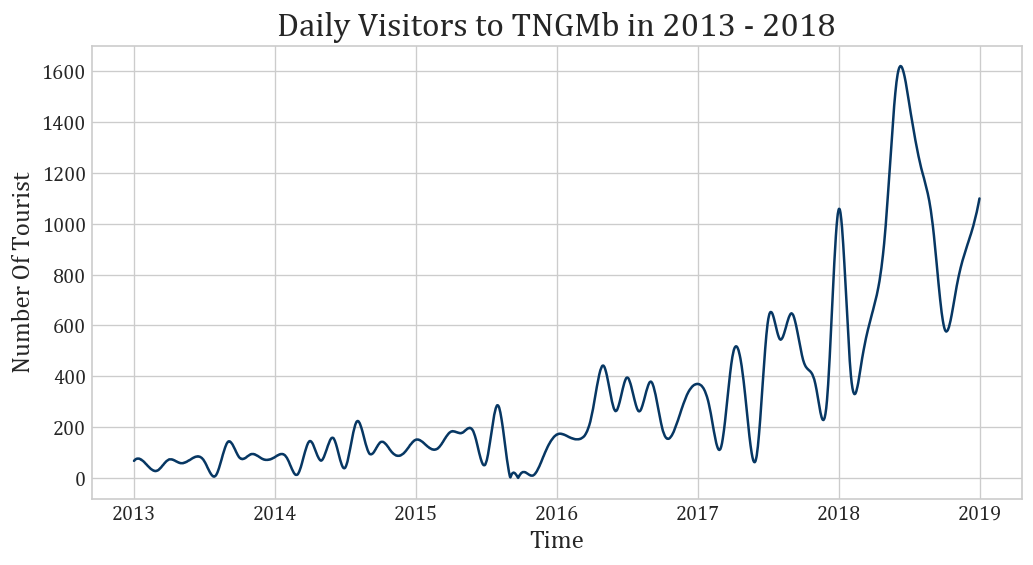

In [5]:
plot_series(series)

In [6]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

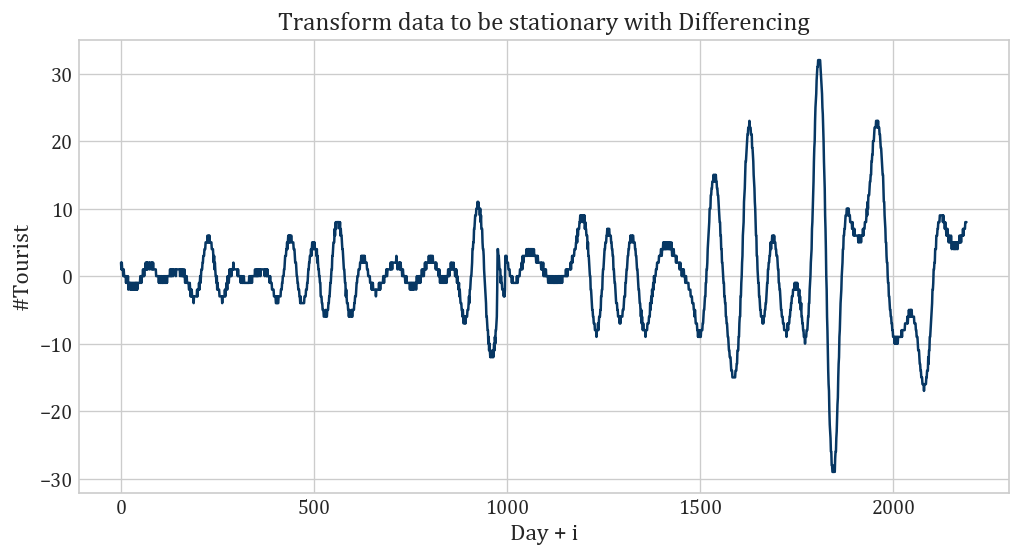

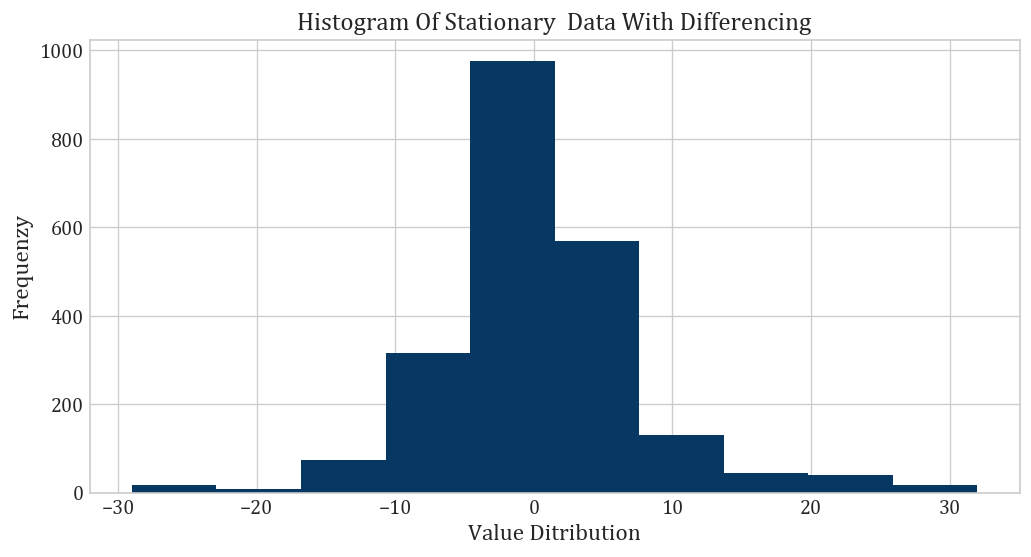

In [7]:
plot_stationary(diff_values)

In [8]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
print('Time series data point dimensions : %d Sample, %d Feature ' % supervised_values.shape)
print('---------------------------------------------------------------------------')
pd.DataFrame(supervised).head(5)

Time series data point dimensions : 2190 Sample, 2 Feature 
---------------------------------------------------------------------------


,0,0
0,0.0,2
1,2.0,1
2,1.0,2
3,2.0,1
4,1.0,1


In [9]:
# split data into train and test-sets
train, test = supervised_values[0:-365], supervised_values[-365:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [10]:
print('Train sample & Data Dimention : %d Sample, %d Feature ' % train_scaled.shape)
print('---------------------------------------------------------------------------')
pd.DataFrame(train_scaled).tail(5)

Train sample & Data Dimention : 1825 Sample, 2 Feature 
---------------------------------------------------------------------------


,0,1
1820,0.489362,0.361702
1821,0.361702,0.276596
1822,0.276596,0.191489
1823,0.191489,0.021277
1824,0.021277,-0.063830


In [11]:
print('Test sample data point dimensions : %d Sample, %d Feature ' % test_scaled.shape)
print('---------------------------------------------------------------------------')
pd.DataFrame(test_scaled).tail(5)

Test sample data point dimensions : 365 Sample, 2 Feature 
---------------------------------------------------------------------------


,0,1
360,-0.063830,-0.063830
361,-0.063830,-0.021277
362,-0.021277,-0.021277
363,-0.021277,-0.021277
364,-0.021277,-0.021277


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (1, 1)                    3         
_________________________________________________________________
dense (Dense)                (1, 1)                    2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00003: early stopping
Time Took :0.96 min


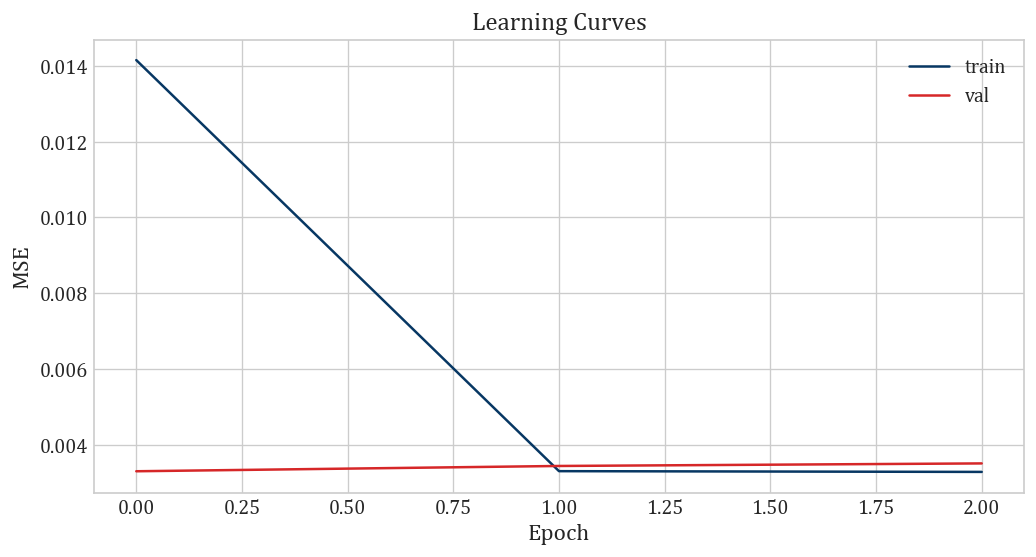

In [12]:
# fit the model
rnn_model = fit_RNN(train_scaled, 1, 3000, 1)

In [13]:
# load model
rnn_model = load_model('model-D11.h5')

Day=1, Predicted=82, Expected=69
Day=2, Predicted=85, Expected=70
Day=3, Predicted=85, Expected=72
Day=4, Predicted=87, Expected=73
Day=5, Predicted=87, Expected=74
Day=6, Predicted=88, Expected=75
Day=7, Predicted=89, Expected=75
Day=8, Predicted=89, Expected=76
Day=9, Predicted=90, Expected=76
Day=10, Predicted=90, Expected=76
Day=11, Predicted=91, Expected=76
Day=12, Predicted=92, Expected=76
Day=13, Predicted=92, Expected=76
Day=14, Predicted=93, Expected=75
Day=15, Predicted=92, Expected=75
Day=16, Predicted=94, Expected=74
Day=17, Predicted=93, Expected=73
Day=18, Predicted=93, Expected=72
Day=19, Predicted=93, Expected=72
Day=20, Predicted=94, Expected=70
Day=21, Predicted=92, Expected=69
Day=22, Predicted=92, Expected=68
Day=23, Predicted=92, Expected=67
Day=24, Predicted=91, Expected=66
Day=25, Predicted=90, Expected=64
Day=26, Predicted=88, Expected=63
Day=27, Predicted=88, Expected=61
Day=28, Predicted=85, Expected=60
Day=29, Predicted=84, Expected=58
Day=30, Predicted=81, E

Day=236, Predicted=140, Expected=120
Day=237, Predicted=134, Expected=124
Day=238, Predicted=129, Expected=128
Day=239, Predicted=124, Expected=132
Day=240, Predicted=119, Expected=135
Day=241, Predicted=113, Expected=137
Day=242, Predicted=108, Expected=140
Day=243, Predicted=106, Expected=141
Day=244, Predicted=101, Expected=143
Day=245, Predicted=99, Expected=144
Day=246, Predicted=96, Expected=144
Day=247, Predicted=94, Expected=144
Day=248, Predicted=93, Expected=143
Day=249, Predicted=92, Expected=143
Day=250, Predicted=93, Expected=141
Day=251, Predicted=91, Expected=140
Day=252, Predicted=93, Expected=138
Day=253, Predicted=93, Expected=136
Day=254, Predicted=94, Expected=134
Day=255, Predicted=95, Expected=132
Day=256, Predicted=97, Expected=129
Day=257, Predicted=98, Expected=126
Day=258, Predicted=100, Expected=123
Day=259, Predicted=103, Expected=120
Day=260, Predicted=105, Expected=117
Day=261, Predicted=108, Expected=114
Day=262, Predicted=110, Expected=111
Day=263, Predi

Day=466, Predicted=179, Expected=124
Day=467, Predicted=179, Expected=120
Day=468, Predicted=178, Expected=116
Day=469, Predicted=177, Expected=112
Day=470, Predicted=177, Expected=108
Day=471, Predicted=176, Expected=104
Day=472, Predicted=176, Expected=100
Day=473, Predicted=175, Expected=96
Day=474, Predicted=175, Expected=92
Day=475, Predicted=174, Expected=88
Day=476, Predicted=174, Expected=85
Day=477, Predicted=174, Expected=82
Day=478, Predicted=174, Expected=79
Day=479, Predicted=174, Expected=76
Day=480, Predicted=173, Expected=74
Day=481, Predicted=174, Expected=72
Day=482, Predicted=174, Expected=70
Day=483, Predicted=174, Expected=69
Day=484, Predicted=176, Expected=68
Day=485, Predicted=176, Expected=68
Day=486, Predicted=178, Expected=69
Day=487, Predicted=179, Expected=70
Day=488, Predicted=180, Expected=72
Day=489, Predicted=182, Expected=74
Day=490, Predicted=183, Expected=77
Day=491, Predicted=186, Expected=80
Day=492, Predicted=187, Expected=83
Day=493, Predicted=18

Day=694, Predicted=76, Expected=92
Day=695, Predicted=80, Expected=93
Day=696, Predicted=84, Expected=94
Day=697, Predicted=87, Expected=95
Day=698, Predicted=91, Expected=96
Day=699, Predicted=95, Expected=98
Day=700, Predicted=99, Expected=99
Day=701, Predicted=102, Expected=101
Day=702, Predicted=106, Expected=103
Day=703, Predicted=110, Expected=104
Day=704, Predicted=112, Expected=106
Day=705, Predicted=116, Expected=108
Day=706, Predicted=120, Expected=110
Day=707, Predicted=123, Expected=112
Day=708, Predicted=126, Expected=114
Day=709, Predicted=129, Expected=116
Day=710, Predicted=132, Expected=118
Day=711, Predicted=135, Expected=120
Day=712, Predicted=137, Expected=122
Day=713, Predicted=140, Expected=124
Day=714, Predicted=143, Expected=127
Day=715, Predicted=146, Expected=129
Day=716, Predicted=148, Expected=131
Day=717, Predicted=150, Expected=132
Day=718, Predicted=151, Expected=134
Day=719, Predicted=154, Expected=136
Day=720, Predicted=156, Expected=138
Day=721, Predic

Day=919, Predicted=395, Expected=111
Day=920, Predicted=391, Expected=120
Day=921, Predicted=387, Expected=130
Day=922, Predicted=383, Expected=140
Day=923, Predicted=378, Expected=150
Day=924, Predicted=372, Expected=161
Day=925, Predicted=368, Expected=171
Day=926, Predicted=360, Expected=182
Day=927, Predicted=356, Expected=192
Day=928, Predicted=347, Expected=202
Day=929, Predicted=341, Expected=212
Day=930, Predicted=334, Expected=221
Day=931, Predicted=327, Expected=231
Day=932, Predicted=322, Expected=239
Day=933, Predicted=314, Expected=248
Day=934, Predicted=309, Expected=255
Day=935, Predicted=301, Expected=262
Day=936, Predicted=296, Expected=269
Day=937, Predicted=291, Expected=274
Day=938, Predicted=283, Expected=278
Day=939, Predicted=278, Expected=282
Day=940, Predicted=275, Expected=285
Day=941, Predicted=270, Expected=286
Day=942, Predicted=265, Expected=286
Day=943, Predicted=263, Expected=285
Day=944, Predicted=261, Expected=283
Day=945, Predicted=260, Expected=280
D

Day=1140, Predicted=168, Expected=153
Day=1141, Predicted=159, Expected=153
Day=1142, Predicted=152, Expected=153
Day=1143, Predicted=145, Expected=152
Day=1144, Predicted=137, Expected=152
Day=1145, Predicted=132, Expected=152
Day=1146, Predicted=127, Expected=152
Day=1147, Predicted=122, Expected=152
Day=1148, Predicted=118, Expected=152
Day=1149, Predicted=115, Expected=152
Day=1150, Predicted=112, Expected=152
Day=1151, Predicted=111, Expected=152
Day=1152, Predicted=110, Expected=152
Day=1153, Predicted=111, Expected=153
Day=1154, Predicted=113, Expected=153
Day=1155, Predicted=114, Expected=153
Day=1156, Predicted=118, Expected=154
Day=1157, Predicted=124, Expected=154
Day=1158, Predicted=129, Expected=155
Day=1159, Predicted=137, Expected=156
Day=1160, Predicted=145, Expected=157
Day=1161, Predicted=155, Expected=158
Day=1162, Predicted=165, Expected=159
Day=1163, Predicted=175, Expected=160
Day=1164, Predicted=187, Expected=161
Day=1165, Predicted=199, Expected=163
Day=1166, Pr

Day=1360, Predicted=522, Expected=255
Day=1361, Predicted=514, Expected=247
Day=1362, Predicted=506, Expected=239
Day=1363, Predicted=499, Expected=231
Day=1364, Predicted=491, Expected=224
Day=1365, Predicted=485, Expected=217
Day=1366, Predicted=478, Expected=210
Day=1367, Predicted=471, Expected=203
Day=1368, Predicted=465, Expected=197
Day=1369, Predicted=460, Expected=191
Day=1370, Predicted=455, Expected=185
Day=1371, Predicted=450, Expected=181
Day=1372, Predicted=447, Expected=176
Day=1373, Predicted=442, Expected=172
Day=1374, Predicted=440, Expected=169
Day=1375, Predicted=438, Expected=165
Day=1376, Predicted=434, Expected=163
Day=1377, Predicted=434, Expected=160
Day=1378, Predicted=431, Expected=158
Day=1379, Predicted=430, Expected=157
Day=1380, Predicted=429, Expected=155
Day=1381, Predicted=427, Expected=155
Day=1382, Predicted=427, Expected=154
Day=1383, Predicted=425, Expected=154
Day=1384, Predicted=424, Expected=154
Day=1385, Predicted=423, Expected=154
Day=1386, Pr

Day=1578, Predicted=899, Expected=394
Day=1579, Predicted=914, Expected=382
Day=1580, Predicted=931, Expected=369
Day=1581, Predicted=947, Expected=355
Day=1582, Predicted=965, Expected=341
Day=1583, Predicted=983, Expected=327
Day=1584, Predicted=1003, Expected=312
Day=1585, Predicted=1023, Expected=297
Day=1586, Predicted=1043, Expected=282
Day=1587, Predicted=1064, Expected=267
Day=1588, Predicted=1086, Expected=252
Day=1589, Predicted=1108, Expected=237
Day=1590, Predicted=1130, Expected=222
Day=1591, Predicted=1152, Expected=207
Day=1592, Predicted=1175, Expected=193
Day=1593, Predicted=1198, Expected=179
Day=1594, Predicted=1221, Expected=165
Day=1595, Predicted=1244, Expected=152
Day=1596, Predicted=1266, Expected=139
Day=1597, Predicted=1289, Expected=128
Day=1598, Predicted=1312, Expected=117
Day=1599, Predicted=1334, Expected=106
Day=1600, Predicted=1356, Expected=97
Day=1601, Predicted=1378, Expected=88
Day=1602, Predicted=1399, Expected=81
Day=1603, Predicted=1420, Expected

Day=1793, Predicted=921, Expected=274
Day=1794, Predicted=929, Expected=288
Day=1795, Predicted=936, Expected=305
Day=1796, Predicted=943, Expected=324
Day=1797, Predicted=950, Expected=344
Day=1798, Predicted=955, Expected=367
Day=1799, Predicted=961, Expected=392
Day=1800, Predicted=967, Expected=418
Day=1801, Predicted=972, Expected=445
Day=1802, Predicted=978, Expected=474
Day=1803, Predicted=982, Expected=504
Day=1804, Predicted=987, Expected=535
Day=1805, Predicted=993, Expected=566
Day=1806, Predicted=998, Expected=598
Day=1807, Predicted=1003, Expected=630
Day=1808, Predicted=1009, Expected=662
Day=1809, Predicted=1014, Expected=694
Day=1810, Predicted=1019, Expected=726
Day=1811, Predicted=1025, Expected=758
Day=1812, Predicted=1030, Expected=789
Day=1813, Predicted=1036, Expected=819
Day=1814, Predicted=1041, Expected=848
Day=1815, Predicted=1047, Expected=876
Day=1816, Predicted=1053, Expected=903
Day=1817, Predicted=1060, Expected=928
Day=1818, Predicted=1065, Expected=952


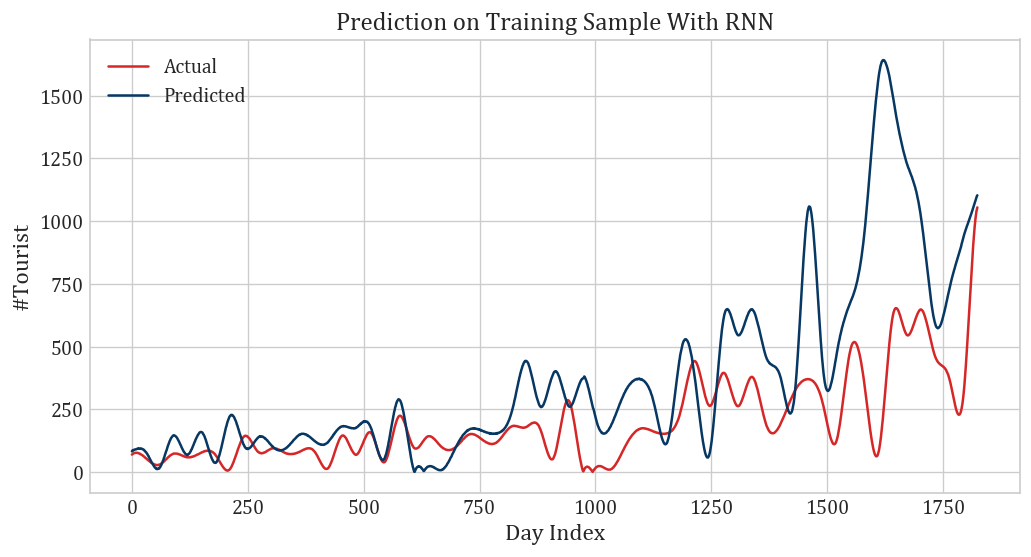

In [14]:
# walk-forward validation on the training data
predictions_train = list()
for i in range(len(train_scaled)):
    # make one-step forecast
    X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
    yhat = forecast_RNN(rnn_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(train_scaled)+1-i)
    # store forecast
    predictions_train.append(yhat)
    expected_train = raw_values[i+1]
    print('Day=%d, Predicted=%.0f, Expected=%.0f' % (i+1, yhat, expected_train))

# report performance
rmse_train = sqrt(mean_squared_error(raw_values[1:len(train_scaled)+1], predictions_train))
print('---------------------------------------------------------------------------')
print('Train RMSE: %.1f' % rmse_train)
print('---------------------------------------------------------------------------')
# line plot of observed vs predicted
plt.plot(raw_values[1:len(train_scaled)+1], label = 'Actual',color='tab:red')
plt.plot(predictions_train, label = 'Predicted',color='#073763ff')
plt.legend(loc='best')
plt.gca().set(title = "Prediction on Training Sample With RNN" , 
                  xlabel='Day Index', 
                  ylabel='#Tourist',)
plt.show()

Day=1, Predicted=1064, Expected=1059
Day=2, Predicted=1064, Expected=1059
Day=3, Predicted=1059, Expected=1057
Day=4, Predicted=1055, Expected=1051
Day=5, Predicted=1046, Expected=1043
Day=6, Predicted=1036, Expected=1032
Day=7, Predicted=1024, Expected=1018
Day=8, Predicted=1009, Expected=1002
Day=9, Predicted=992, Expected=985
Day=10, Predicted=975, Expected=965
Day=11, Predicted=955, Expected=943
Day=12, Predicted=932, Expected=920
Day=13, Predicted=909, Expected=896
Day=14, Predicted=885, Expected=870
Day=15, Predicted=859, Expected=844
Day=16, Predicted=833, Expected=816
Day=17, Predicted=805, Expected=788
Day=18, Predicted=777, Expected=759
Day=19, Predicted=748, Expected=730
Day=20, Predicted=719, Expected=701
Day=21, Predicted=690, Expected=672
Day=22, Predicted=661, Expected=643
Day=23, Predicted=632, Expected=615
Day=24, Predicted=604, Expected=586
Day=25, Predicted=575, Expected=559
Day=26, Predicted=548, Expected=533
Day=27, Predicted=522, Expected=507
Day=28, Predicted=496

Day=221, Predicted=1181, Expected=1181
Day=222, Predicted=1176, Expected=1175
Day=223, Predicted=1170, Expected=1170
Day=224, Predicted=1165, Expected=1164
Day=225, Predicted=1159, Expected=1158
Day=226, Predicted=1153, Expected=1152
Day=227, Predicted=1147, Expected=1146
Day=228, Predicted=1141, Expected=1140
Day=229, Predicted=1135, Expected=1134
Day=230, Predicted=1129, Expected=1127
Day=231, Predicted=1121, Expected=1120
Day=232, Predicted=1114, Expected=1113
Day=233, Predicted=1107, Expected=1106
Day=234, Predicted=1100, Expected=1098
Day=235, Predicted=1091, Expected=1090
Day=236, Predicted=1083, Expected=1081
Day=237, Predicted=1074, Expected=1072
Day=238, Predicted=1065, Expected=1063
Day=239, Predicted=1056, Expected=1053
Day=240, Predicted=1045, Expected=1042
Day=241, Predicted=1034, Expected=1031
Day=242, Predicted=1023, Expected=1020
Day=243, Predicted=1012, Expected=1008
Day=244, Predicted=1000, Expected=995
Day=245, Predicted=986, Expected=982
Day=246, Predicted=973, Expe

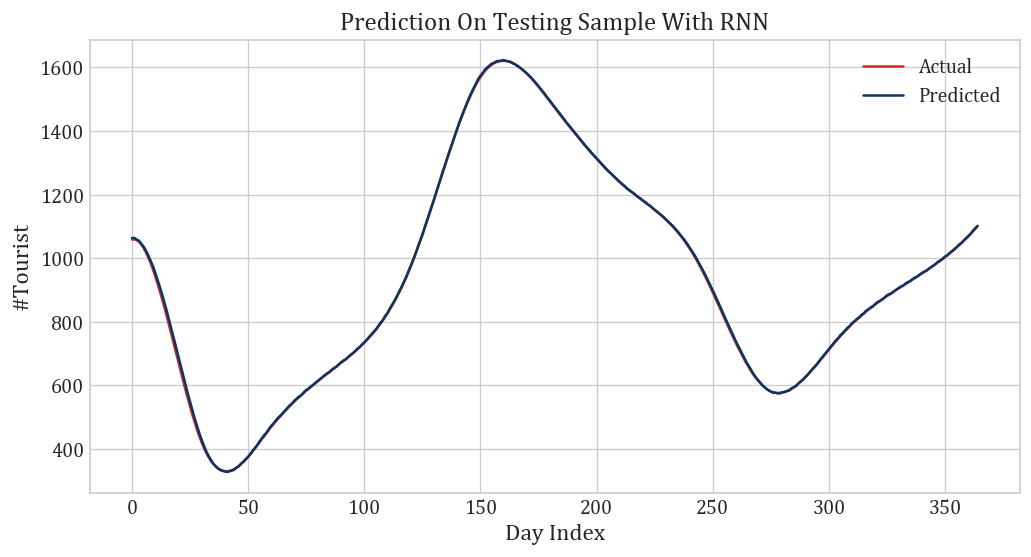

In [15]:
# walk-forward validation on the test data
predictions_test = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_RNN(rnn_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions_test.append(yhat)
    expected_test = raw_values[len(train) + i + 1]
    print('Day=%d, Predicted=%.0f, Expected=%.0f' % (i+1, yhat, expected_test))

# report performance
rmse_test = sqrt(mean_squared_error(raw_values[-365:], predictions_test))
print('---------------------------------------------------------------------------')
print('Test RMSE: %.1f' % rmse_test)
print('---------------------------------------------------------------------------')
# line plot of observed vs predicted
plt.plot(raw_values[-365:], label = 'Actual',color='tab:red')
plt.plot(predictions_test, label = 'Predicted',color='#073763ff')
plt.legend(loc='best')
plt.gca().set(title = "Prediction On Testing Sample With RNN" , 
                  xlabel='Day Index', 
                  ylabel='#Tourist',)
plt.show()